In [26]:
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions
import pandas as pd
from pyspark.mllib.linalg import DenseVector
from numpy import array
from math import sqrt
from pyspark.ml.clustering import KMeans
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
sqlContext = SQLContext(sc)

In [3]:
dataDF = sqlContext.read.load('file:///home/cloudera/coursera/courseraDataSimulation/course4-ML/MW-timestamp-NEW.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [4]:
dataDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,1587257,793628.0,458201.7724491035,0,1587256
air_pressure,1587257,916.8301266904964,3.051593126680745,905.0,929.5
air_temp,1587257,61.85144042834878,11.833623786835721,31.64,99.5
avg_wind_direction,1586824,161.96537927331576,95.20811970203971,0.0,359.0
avg_wind_speed,1586824,2.774272067979844,2.0607577935630355,0.0,32.3
max_wind_direction,1586824,163.40304784903682,92.3672342806429,0.0,359.0
max_wind_speed,1586824,3.3998134008569685,2.423167433617133,0.1,36.0
min_wind_direction,1586824,166.82637078844283,97.46274620077615,0.0,359.0
min_wind_speed,1586824,2.1331304542917913,1.745345084932679,0.0,32.0


In [5]:
dataDF.count()

1587257

In [6]:
#Down sample to take every 10th value

#filtered = dataDF.filter((dataDF.rowID % 10) == 0)

filtered = dataDF

In [7]:
filtered.count()

1587257

In [8]:
#SELECT required columns and drop rows with NULL

cols = [
 'air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 'max_wind_speed',
 'relative_humidity']

workingDF = filtered.select(cols).na.drop()

In [9]:
workingDF.take(2)

[Row(air_pressure=912.3, air_temp=64.76, avg_wind_direction=97.0, avg_wind_speed=1.2, max_wind_direction=106.0, max_wind_speed=1.6, relative_humidity=60.5),
 Row(air_pressure=912.3, air_temp=63.86, avg_wind_direction=161.0, avg_wind_speed=0.8, max_wind_direction=215.0, max_wind_speed=1.5, relative_humidity=39.9)]

In [10]:
#CONVERT SPEED from meters/sec to miles per hour
workingDF = workingDF.withColumn('avg_wind_speed', workingDF.avg_wind_speed * 2.236)
workingDF = workingDF.withColumn('max_wind_speed', workingDF.max_wind_speed * 2.236)

In [11]:
workingDF.columns

['air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'relative_humidity']

In [12]:
#ASSEMBLE all the features.

from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=cols, outputCol="features_pre")
assembled = assembler.transform(workingDF)

In [13]:
#SCALE the dataset.

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_pre", outputCol="features",withStd=True, withMean=True)

# Fit the StandardScaler
scalerModel = scaler.fit(assembled)

# Normalize each feature
scaledData = scalerModel.transform(assembled)

In [14]:
scaledData = scaledData.select("features")
scaledData.persist()

DataFrame[features: vector]

In [15]:
# Let us write a function that evaluates the Errors: WSSE  -  Within Set Sum of Squared Errors.

def wssse(featuresAndPrediction, model):
    # Get centers of all clusters
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    # Map to a collection of arrays
    arrayCollection   = featuresAndPrediction.rdd.map(array)
    # Given a point, return its distance from Center of the Class assigned

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        return sqrt(sum([x*x for x in (point - center)]))
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)

In [ ]:
#ELBOW method

wssseList = []

for howManyClusters in range(2,31):
    #train kmeans
    print "Training for k = {} ".format(howManyClusters)
    kmeans      = KMeans(k=howManyClusters, seed = 1)
    %time model       = kmeans.fit(scaledData)
    transformed = model.transform(scaledData)
    featuresAndPrediction     = transformed.select("features", "prediction")
    
    #get wsse
    W = wssse(featuresAndPrediction, model)
    print "WSSSE = {} ".format(W)
    
    #store wsse so we can plot it
    wssseList.append(W)

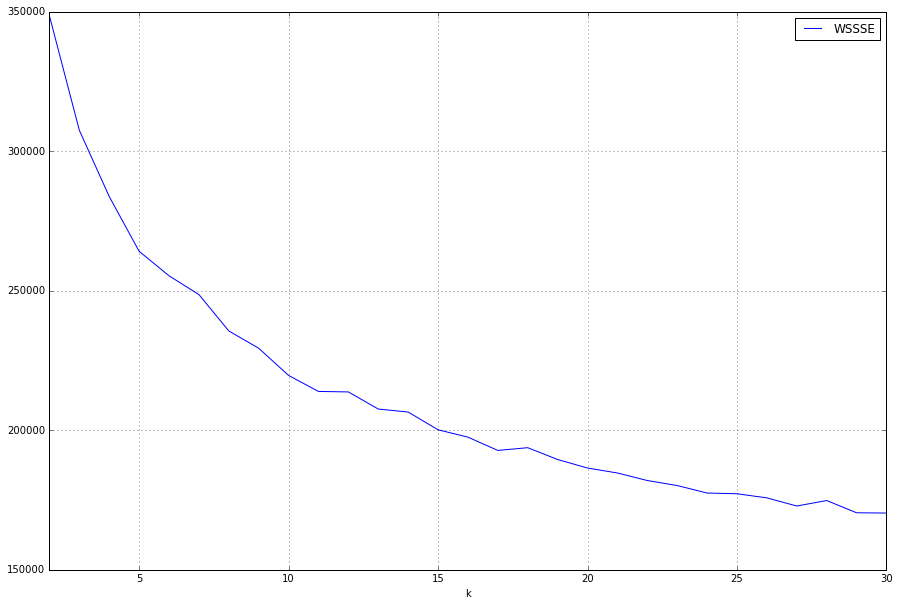

In [63]:
wssseDF = pd.DataFrame({'WSSSE' : wssseList, 'k' : range(2,31) })
wssseDF.plot(y='WSSSE', x='k', figsize=(15,10), grid=True)

In [30]:
# Review the graph above and run k-means for a specific k :

kmeans                    = KMeans(k=11, seed = 1)
%time model               = kmeans.fit(scaledData)
%time transformed         = model.transform(scaledData)
%time featuresAndPrediction     = transformed.select("features", "prediction")
%time W                   = wssse(featuresAndPrediction, model)
print(W)

CPU times: user 21 ms, sys: 17 ms, total: 38 ms
Wall time: 1min 11s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 83 ms
CPU times: user 1e+03 µs, sys: 2 ms, total: 3 ms
Wall time: 15.8 ms
CPU times: user 27 ms, sys: 22 ms, total: 49 ms
Wall time: 2min 29s
2176904.47438


In [31]:
scaledData.count()

1586824

In [32]:
#How many members per clusters
import pyspark.sql.functions as func

featuresAndPrediction.groupby(featuresAndPrediction.prediction).agg(func.count('prediction')).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         0|           194305|
|         1|           268653|
|         2|           139190|
|         3|            46260|
|         4|           165531|
|         5|            98646|
|         6|           134739|
|         7|           218817|
|         8|           103182|
|         9|           151954|
|        10|            65547|
+----------+-----------------+



In [33]:
from pandas.tools.plotting import parallel_coordinates
import numpy as np

In [34]:
colNames = ['air_pressure','air_temp','avg_wind_direction','avg_wind_speed',
'max_wind_direction','max_wind_speed','relative_humidity', 'prediction']

In [35]:
# Get the cluster centers
C = model.clusterCenters()

# Zip with a column called 'prediction' (index)
Z = [np.append(A, index) for index, A in enumerate(C)]

# Convert to pandas for plotting
P = pd.DataFrame(Z, columns=colNames)

In [36]:
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,-0.004687,0.699587,0.414523,0.426162,0.528089,0.385184,-0.264520,0.0
1,0.393102,0.586472,-1.281209,-0.466651,-1.137944,-0.471419,-0.826856,1.0
2,0.076304,-0.692853,-1.206120,-0.550541,-1.059591,-0.567700,0.770429,2.0
3,-1.548529,-1.419511,0.386325,2.251262,0.493777,2.219539,1.502907,3.0
4,0.238064,-0.968609,0.629296,-0.551844,0.817998,-0.536381,1.124242,4.0
5,-0.787569,-0.128662,0.446377,1.572075,0.529115,1.498585,0.246677,5.0
6,0.331329,0.745599,1.294204,-0.653199,1.556855,-0.608333,-0.746625,6.0
7,-0.333035,0.569264,0.130000,-0.698217,0.310552,-0.710859,-0.379277,7.0
8,1.297904,-0.239471,-1.154774,1.761433,-1.050014,1.870008,-1.125873,8.0
9,-0.850115,-1.188582,0.380447,0.370369,0.474192,0.358627,1.360249,9.0


## Plots

## Dry Days

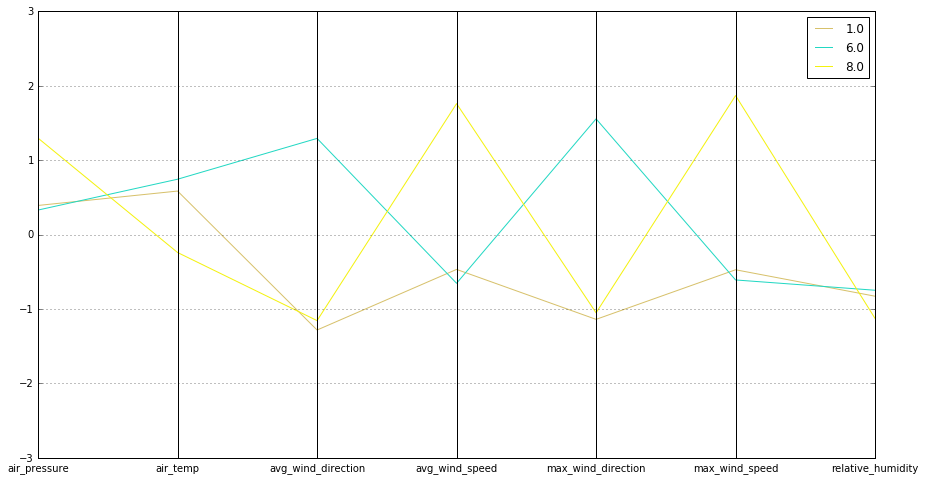

In [37]:
# Parallel Coordinates Plot 1: Dry Days (Low Humidity)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
parallel_coordinates(P[P['relative_humidity']< -0.5], 'prediction')

## Warm Days

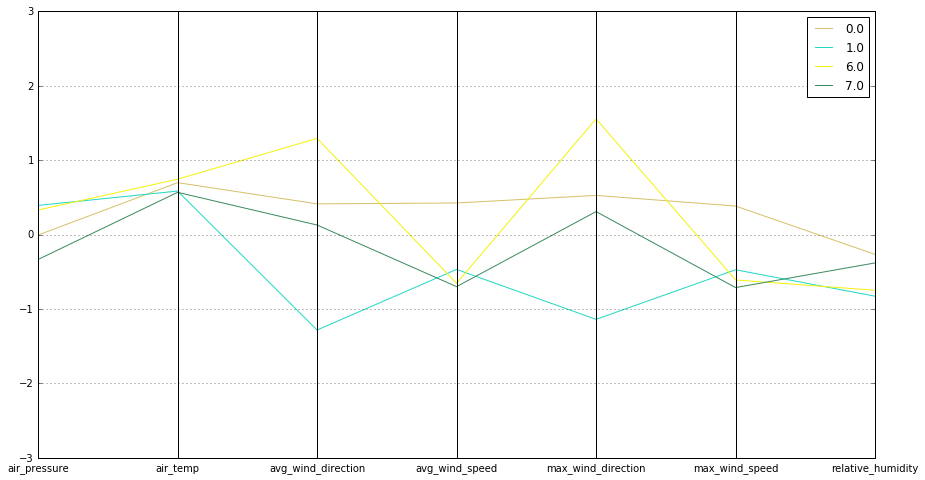

In [38]:
# Parallel Coordinates Plot 1: Warm Days (High Temperature)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
parallel_coordinates(P[P['air_temp']> 0.5], 'prediction')

## Cool and Rainy Days

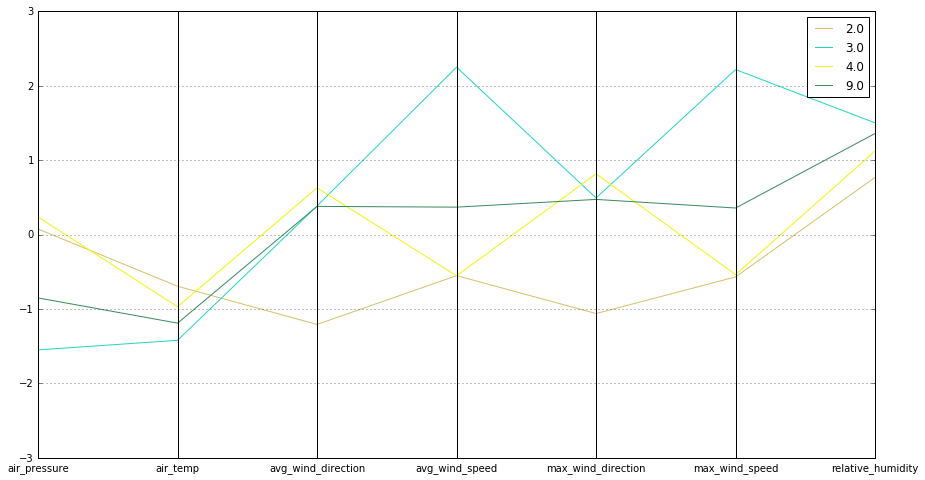

In [39]:
# Parallel Coordinates Plot 1: Cool and Possibily Rainy Days (High Humidity, Low Temp)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
parallel_coordinates(P[(P['relative_humidity']>0.5) & (P['air_temp']< 0.5)], 'prediction')